# Task 1: Term Deposit Subscription Prediction

## Objective
Predict whether a bank customer will subscribe to a term deposit based on marketing campaign data.

## Dataset
Data of bank customers used to predict if they will subscribe to a term deposit.

In [46]:
import pandas as pd       # For data handling
import numpy as np        # For math
import matplotlib.pyplot as plt   # For basic plots
import seaborn as sns     # For nicer plots

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

import shap
import warnings
warnings.filterwarnings("ignore") # it will ignore the warnings

#### Loading and Exploring data

In [3]:
# Load the dataset
data = pd.read_csv("bank-additional-full.csv")

In [4]:
# Peek at first 5 rows
data.head()

,Unnamed: 0,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Check column info and types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41205 entries, 0 to 41204
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      41205 non-null  int64  
 1   age             41205 non-null  int64  
 2   job             41205 non-null  object 
 3   marital         41188 non-null  object 
 4   education       41205 non-null  object 
 5   default         41205 non-null  object 
 6   housing         41205 non-null  object 
 7   loan            41205 non-null  object 
 8   contact         41205 non-null  object 
 9   month           41205 non-null  object 
 10  day_of_week     41205 non-null  object 
 11  duration        41205 non-null  int64  
 12  campaign        41205 non-null  int64  
 13  pdays           41205 non-null  int64  
 14  previous        41205 non-null  int64  
 15  poutcome        41205 non-null  object 
 16  emp.var.rate    41205 non-null  float64
 17  cons.price.idx  41205 non-null 

#### Handling missing Vaules

In [6]:
# Check for missing values
data.isnull().sum()

Unnamed: 0         0
age                0
job                0
marital           17
education          0
default            0
housing            0
loan               0
contact            0
month              0
day_of_week        0
duration           0
campaign           0
pdays              0
previous           0
poutcome           0
emp.var.rate       0
cons.price.idx     0
cons.conf.idx      0
euribor3m          0
nr.employed        0
y                  0
dtype: int64

In [7]:
# Drop unnecessary index column
data = data.drop('Unnamed: 0', axis=1) #axis:1 means drop the column

In [8]:
# Fill missing values in 'marital'
data['marital'] = data['marital'].fillna('unknown')

#### EDA 
EDA helps us see trends, check imbalances, and plan preprocessing.

In [9]:
# Check target distribution
data['y'].value_counts()

y
no     36565
yes     4640
Name: count, dtype: int64

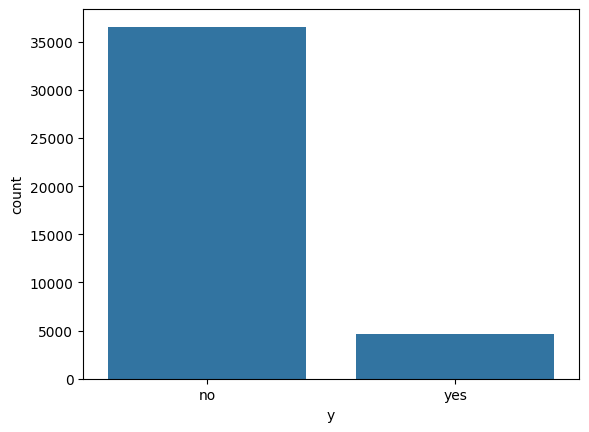

In [10]:
sns.countplot(x='y', data=data)
plt.show()

In [11]:
# Check numeric feature statistics
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000,41205.000000
mean,40.021988,258.260963,2.566946,962.490523,0.172892,0.082429,93.575806,-40.503507,3.621844,5167.061104
std,10.419599,259.228459,2.769625,186.873817,0.494811,1.570864,0.578762,4.627458,1.734304,72.247265
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


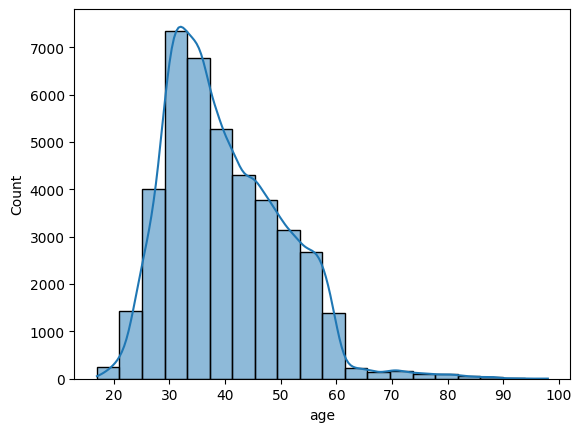

In [12]:
sns.histplot(data['age'], bins=20, kde=True)
plt.show()

In [13]:
data['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2941
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

#### Training the Model

In [15]:
# Convert categorical columns using one-hot encoding
data = pd.get_dummies(data, drop_first=True)
data.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,True,False,False
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,True,False,False
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,True,False,False
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,True,False,False
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,False,False,False,True,False,False,False,True,False,False


##### Train-test-split
Here we split data into training and testing parts. One part train the model and other test it on unseen data.

In [16]:
# Separate features and target
x = data.drop('y_yes', axis=1)
y = data['y_yes']

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

##### Train Logistic Regression Model
We are building a model to predict if a customer will subscribe.

In [47]:
model = LogisticRegression(max_iter=1000)
# Train the model
model.fit(x_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

##### Evaluate the model
Here we check how well our model predicts.

In [26]:
# Make predictions
y_pred = model.predict(x_test)
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[7082  207]
 [ 541  411]]


In [27]:
# F1-Score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

F1-Score: 0.5235668789808917


In [30]:
# ROC AUC
y_prob = model.predict_proba(x_test)[:, 1]  # predicted probabilities
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC:", roc_auc)

ROC AUC: 0.9340450269832175


#### Predictions using SHAP

Prediction 1


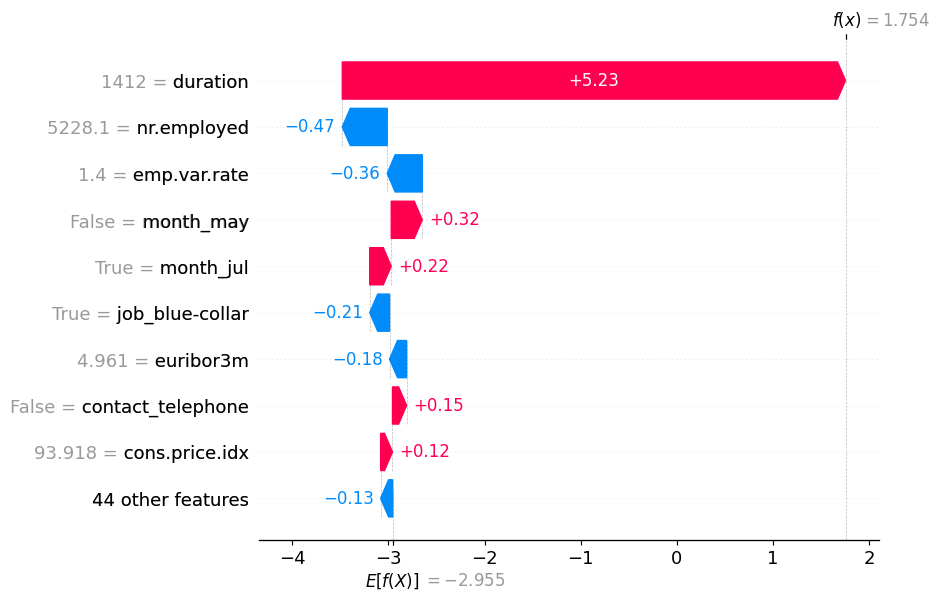

Prediction 2


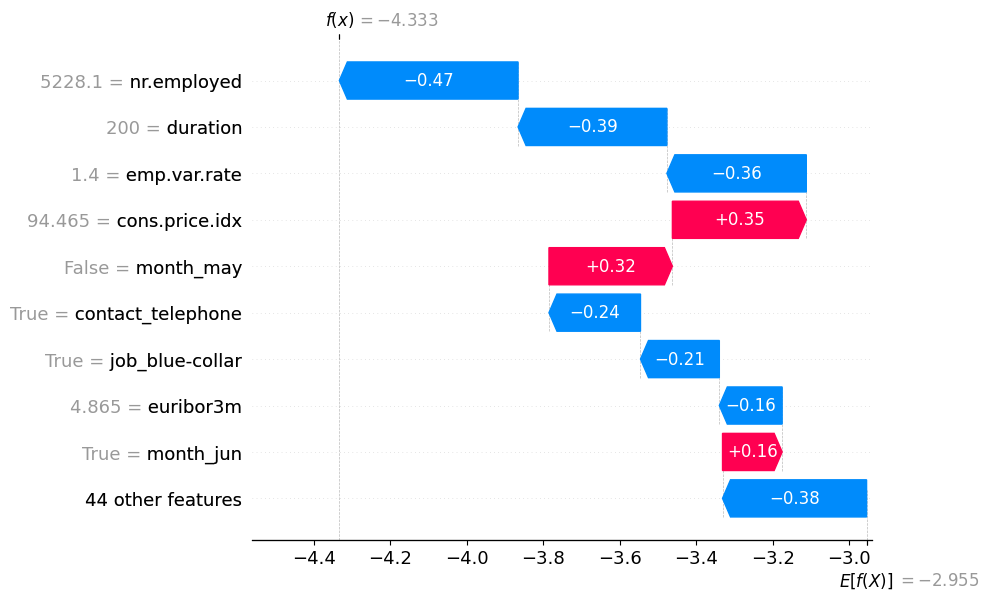

Prediction 3


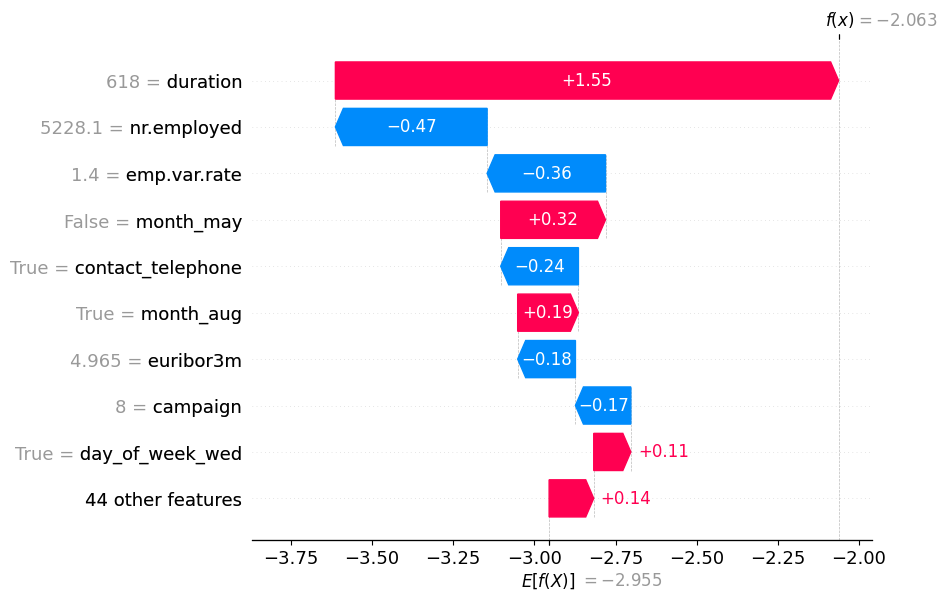

Prediction 4


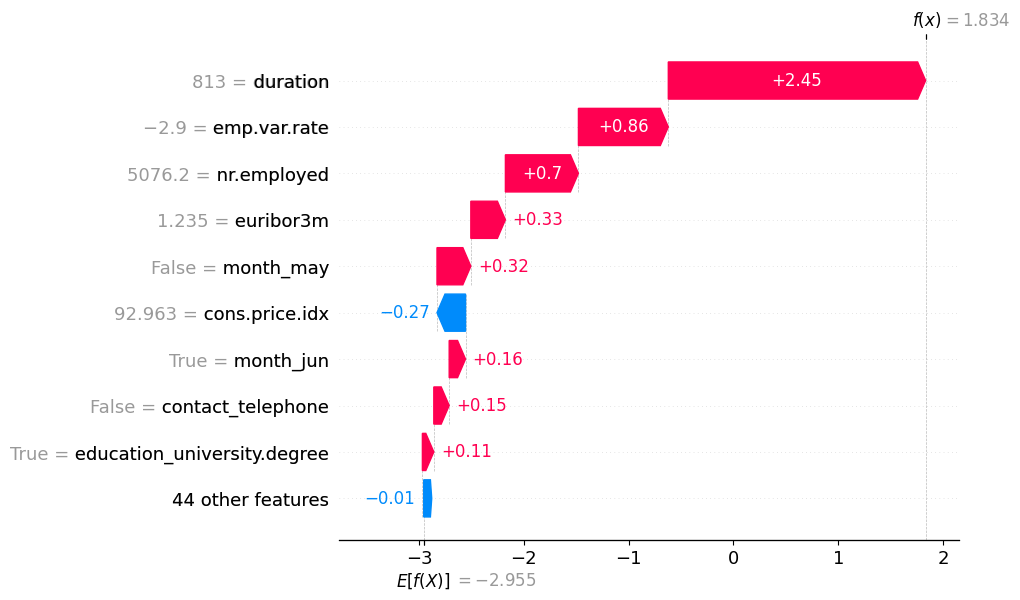

Prediction 5


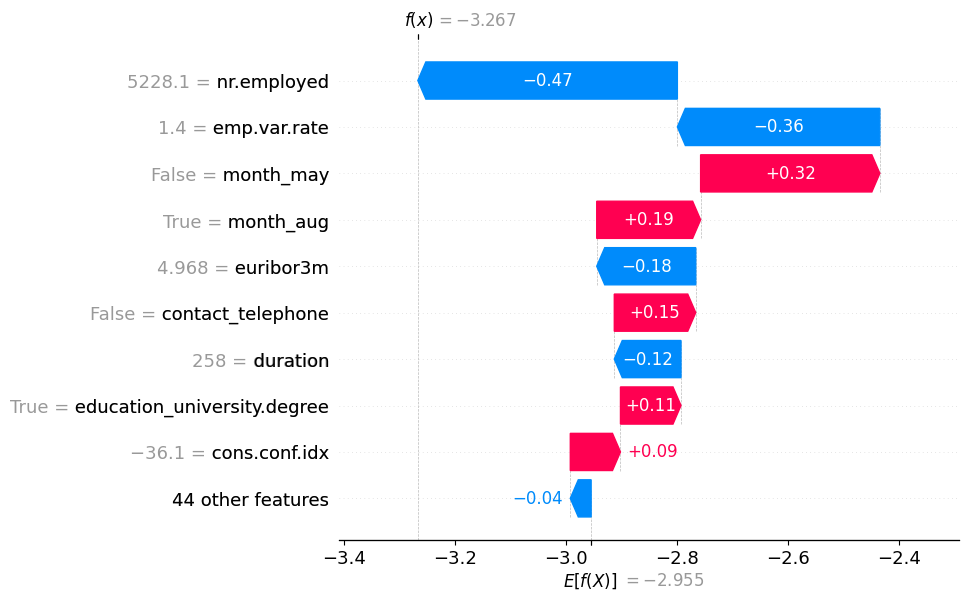

In [34]:
# Create SHAP explainer
explainer = shap.Explainer(model, x_train)

# Get SHAP values for test set
shap_values = explainer(x_test)
# Plot explanations for first 5 predictions
for i in range(5):
    print(f"Prediction {i+1}")
    shap.plots.waterfall(shap_values[i])

## Conclusion
- The model predicts whether a customer will subscribe to a term deposit.
- Logistic Regression achieved F1-Score ~0.52 and ROC AUC ~0.93.
- Economic indicators (euribor3m, cons.price.idx) and customer info (age, balance) were important features.
- SHAP analysis showed which features pushed predictions toward yes or no.
- The model can help the bank target customers more effectively.